In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS= 3
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size= (IMAGE_SIZE,IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

Found 16011 files belonging to 10 classes.


In [4]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [5]:
len(dataset)

501

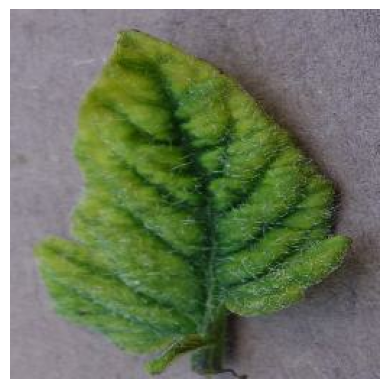

In [6]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.axis("off")
    # print(image_batch[0].shape)

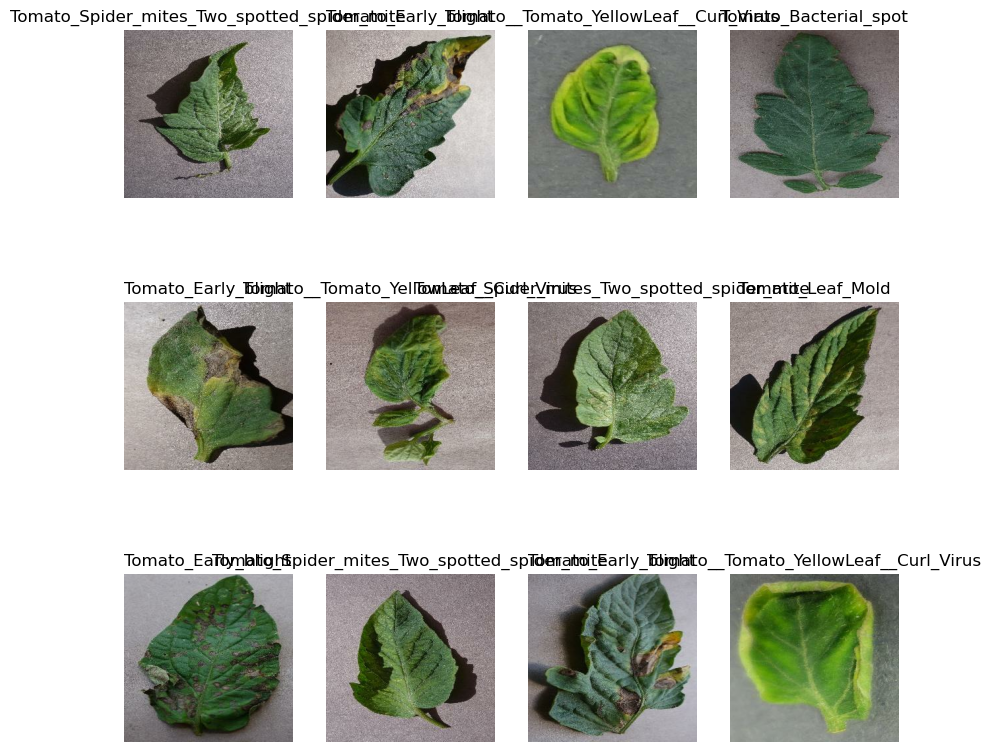

In [7]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [8]:
# 80% ==> training
# 20% ==> 10% validation, 10% test

In [9]:
train_size = 0.8
len(dataset)*train_size

400.8

In [10]:
train_ds = dataset.take(400)
len(train_ds)

400

In [11]:
test_ds = dataset.skip(400)
len(test_ds)

101

In [12]:
val_size = 0.1
len(dataset)*val_size

50.1

In [13]:
val_ds = test_ds.skip(50)
len(val_ds)

51

In [14]:
def get_dataset_partitioning_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
        ds_size = len(ds)
        if shuffle:
            df = ds.shuffle(shuffle_size, seed=12)
        train_size = int(train_split * ds_size)
        val_size = int(val_split * ds_size)
        train_ds = ds.take(train_size)
        val_ds = ds.skip(train_size).take(val_size)
        test_ds = ds.skip(train_size).take(val_size)
        return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds= get_dataset_partitioning_tf(dataset)

In [16]:
len(train_ds)

400

In [17]:
len(val_ds)

50

In [18]:
len(test_ds)

50

In [19]:
train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

##### Resizing the images, even thought they are 256 but the layers will go to the ult model and if there are images that are not 256 it will take care of resizing it.

In [20]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
    
])

###### Data Ugmentation: for the robustness of the model. This help to rotate the images and also add more images for the robustness of the model.

In [21]:
data_ugmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
    
])

##### Training the Model: This will be a convolutional Neural Network, train the network and measure the accuracy with the test dataset. 

In [22]:
input_shape=(BATCH_SIZE, IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 10
model = models.Sequential([
    resize_and_rescale,
    data_ugmentation,
    layers.Conv2D(32,(3,3),activation="relu", input_shape=input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation = "relu"),
    layers.Dense(n_classes,activation = "softmax"),
    
])
model.build(input_shape=input_shape)

C:\Users\annla\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 2304)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 10)               │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 278,346 (1.06 MB)

 Trainable params: 278,346 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
model.compile(
    optimizer = "adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ["accuracy"]
)

In [25]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data = val_ds, 
)

Epoch 1/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 360s 891ms/step - accuracy: 0.3288 - loss: 1.8614 - val_accuracy: 0.4363 - val_loss: 1.8814
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 297s 743ms/step - accuracy: 0.6571 - loss: 0.9596 - val_accuracy: 0.5694 - val_loss: 1.3285
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 288s 720ms/step - accuracy: 0.7679 - loss: 0.6681 - val_accuracy: 0.6631 - val_loss: 1.3163
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 281s 702ms/step - accuracy: 0.8127 - loss: 0.5310 - val_accuracy: 0.5756 - val_loss: 2.0113
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 281s 703ms/step - accuracy: 0.8350 - loss: 0.4621 - val_accuracy: 0.8050 - val_loss: 0.5504
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 280s 701ms/step - accuracy: 0.8610 - loss: 0.4058 - val_accuracy: 0.7925 - val_loss: 0.6497
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 294s 736ms/step - accuracy: 0.8742 - loss: 0.3651 - val_accuracy: 0.8219 - val_loss: 0.5317
Epoch 8/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 279s 699ms/step - accuracy: 0.9004 -

In [26]:
score = model.evaluate(test_ds)

50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 204ms/step - accuracy: 0.9740 - loss: 0.1092


In [27]:
score

[0.1256599873304367, 0.9668750166893005]

In [28]:
history

In [29]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 400}

In [30]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [31]:
acc= history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

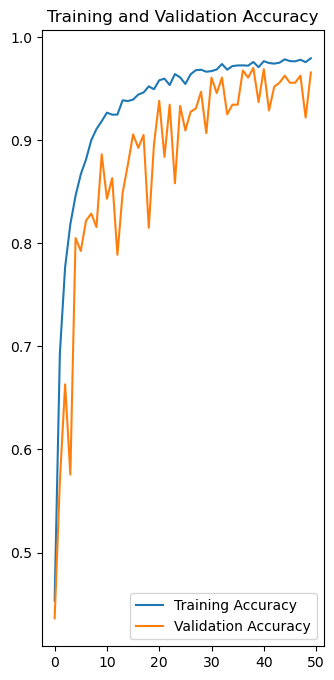

In [32]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label = 'Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

first Image to predict
first image's actual label Tomato_Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
pridected label Tomato_Late_blight


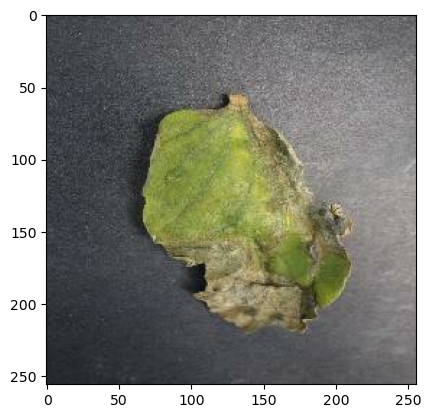

In [33]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first Image to predict")
    plt.imshow(first_image)
    print("first image's actual label", class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("pridected label",class_names[np.argmax(batch_prediction[0])])

In [34]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0) # create a batch
    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


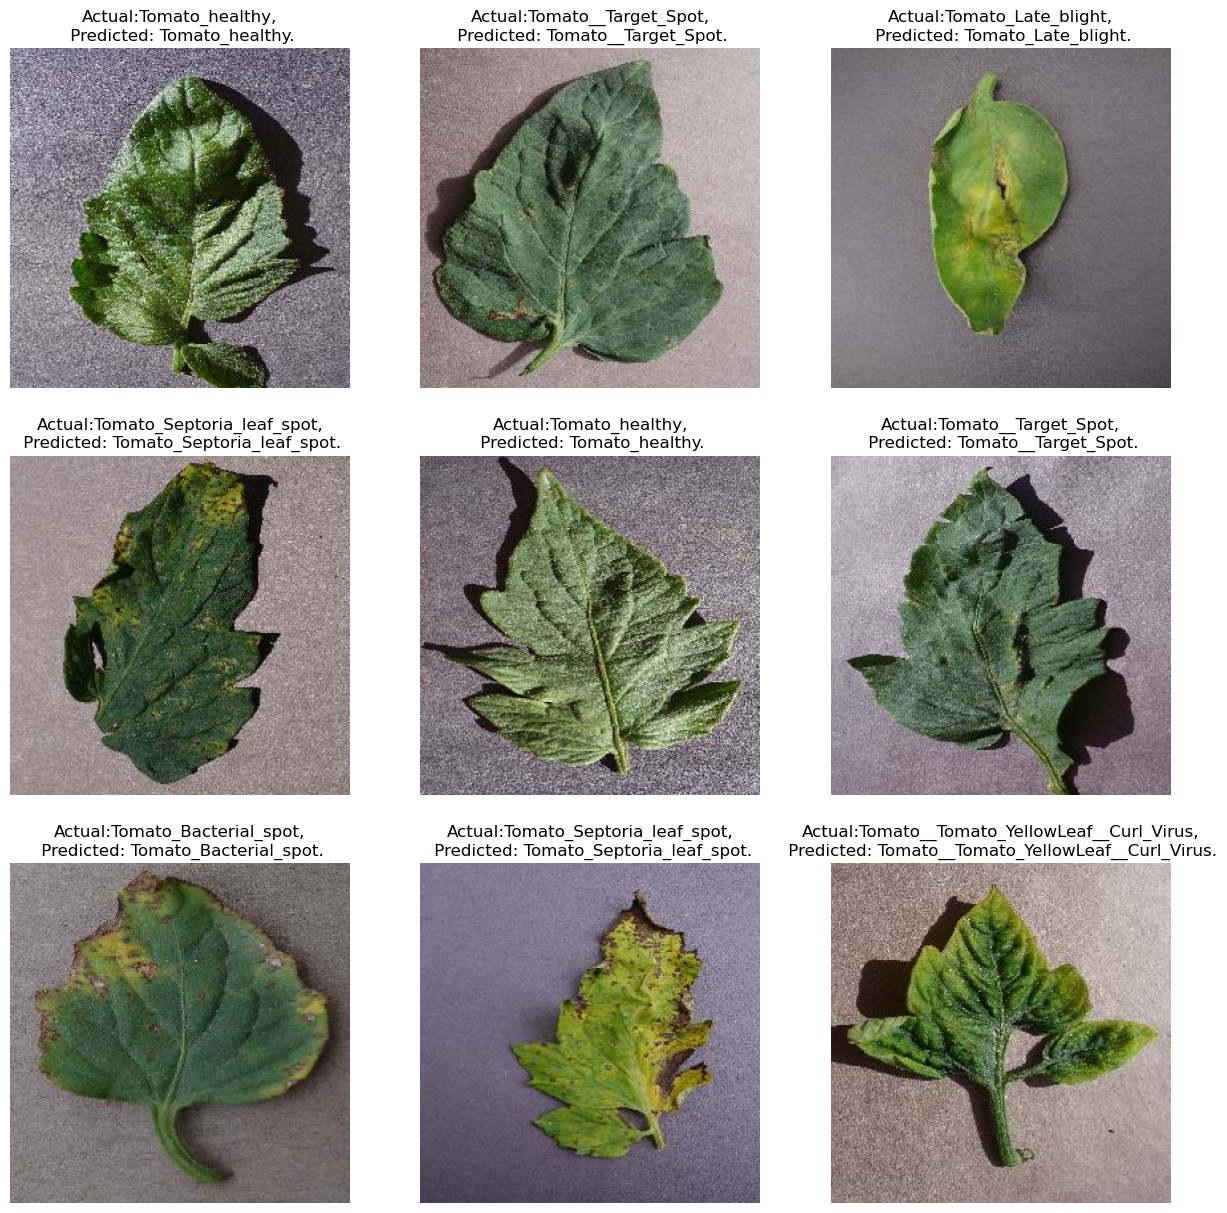

In [35]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual:{actual_class},\n Predicted: {predicted_class}.")
        plt.axis("off")
        

In [46]:
model_version = max([int(i) for i in (os.listdir("../saved_models")+[0])]) + 1
model.save(f"../saved_models/{model_version}/tomatoes_model.h5")


In [ ]:
# model.save("../saved_models/tomatoes_model.h5")